## Blendshape coefficients extraction

In [21]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2

In [22]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [23]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task', delegate= "CPU")
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

I0000 00:00:1706024457.292129 3301626 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706024457.387236 3306528 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: Quadro RTX 6000/PCIe/SSE2
W0000 00:00:1706024457.395474 3301626 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
cap = cv2.VideoCapture("WDA_BarackObama_000.mp4")
frames = []
ret = True
while ret:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    frames.append(frame)

In [25]:
frame_idx = 100
image = mp.Image(
    image_format=mp.ImageFormat.SRGB, data=frames[frame_idx]
)
detection_result = detector.detect(image)
frame_scores = np.array([blendshape.score for blendshape in detection_result.face_blendshapes[0]])
blendshape_names = [blendshape.category_name for blendshape in detection_result.face_blendshapes[0]]

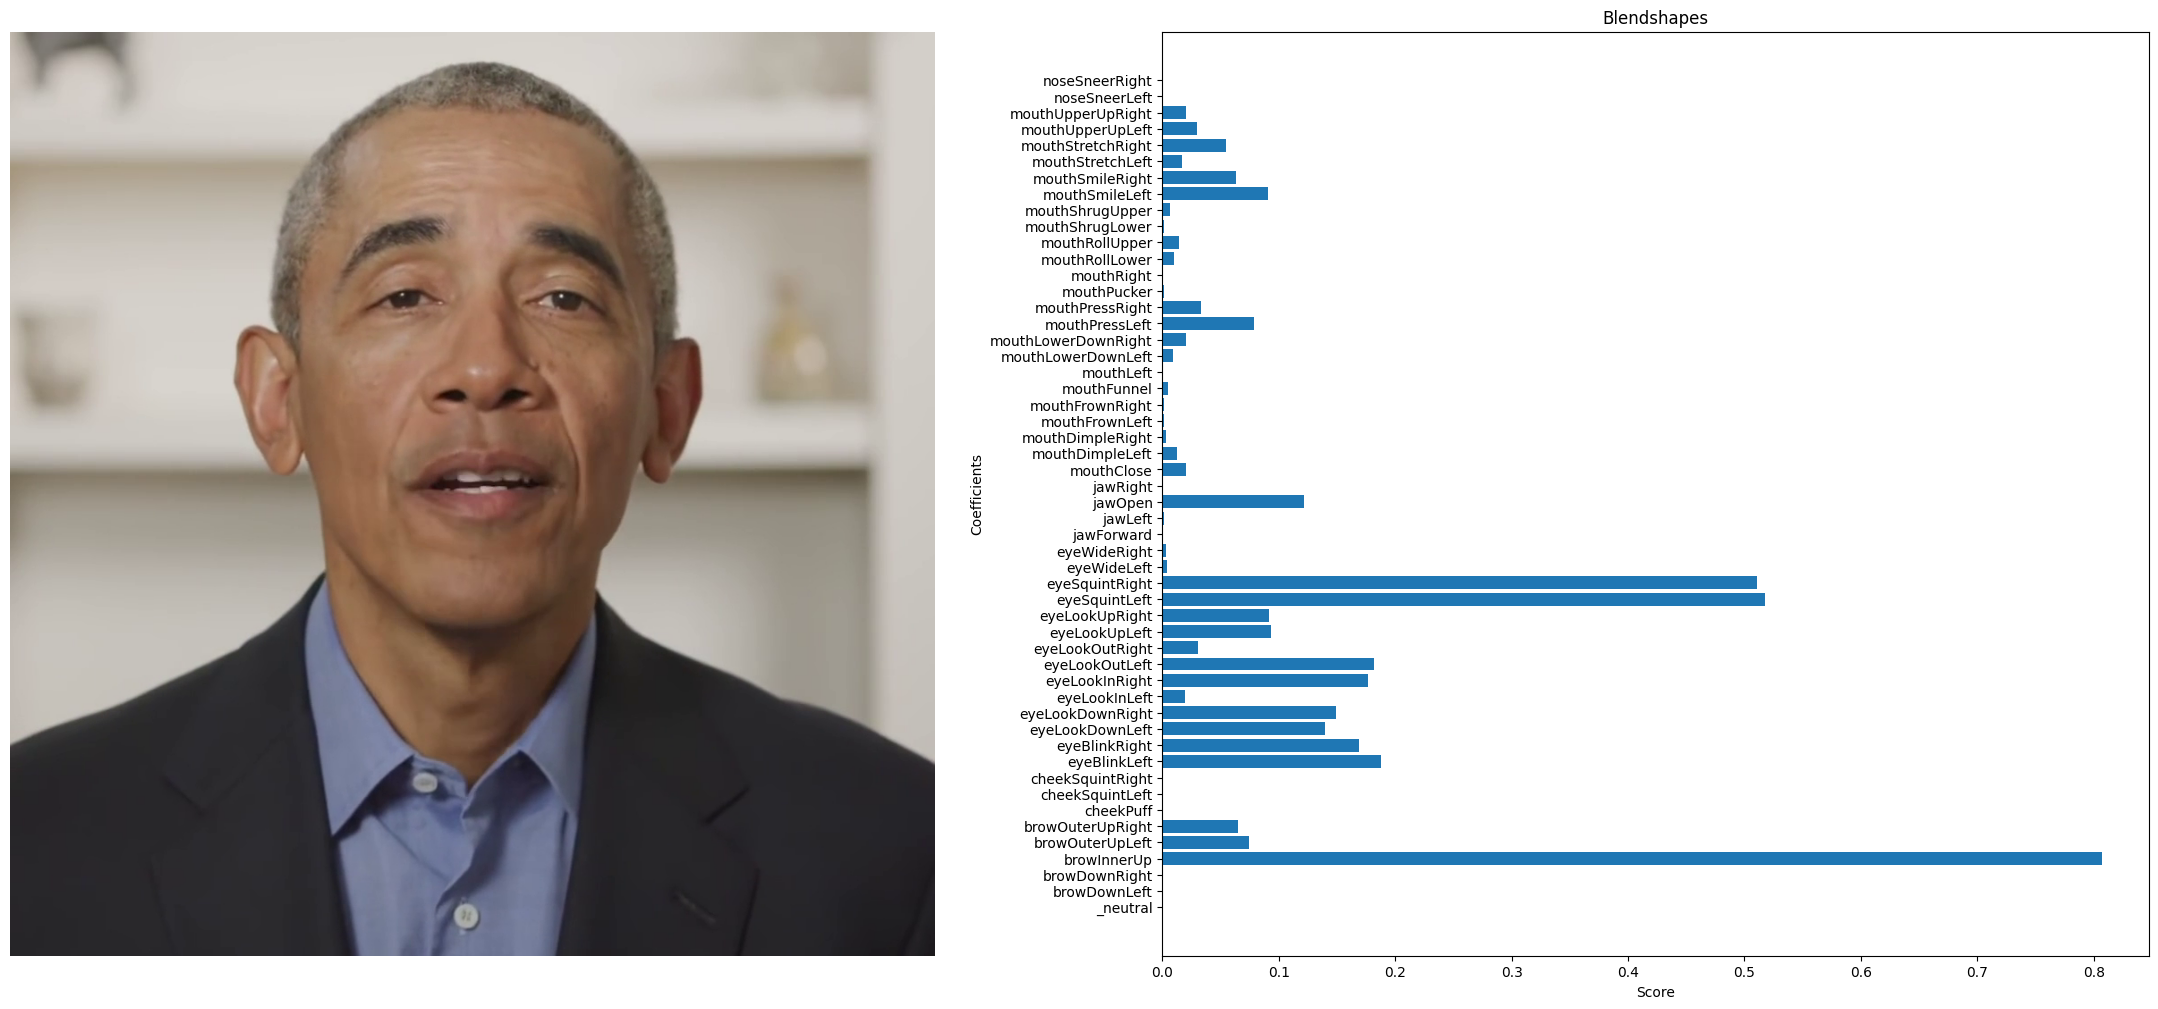

In [26]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(1, 2, figsize=(28, 12))

ax[0].imshow(frames[100])
ax[0].axis(False)

ax[1].barh(blendshape_names, frame_scores)
ax[1].set_ylabel("Coefficients")
ax[1].set_xlabel("Score") 
ax[1].set_title("Blendshapes")
plt.show()

In [61]:
def smooth_array(arr, window=3):
    kernel = np.array([1] * window) / window
    smoothed_arr = np.ones_like(arr)

    for i in range(arr.shape[1]):
        smoothed_arr[:, i] = np.convolve(arr[:, i], kernel, mode='same')    
    return smoothed_arr

In [62]:
video_coeffs = []
for frame in frames:
    image = mp.Image(
        image_format=mp.ImageFormat.SRGB, data=frame
    )
    detection_result = detector.detect(image)
    frame_coeffs = np.array([blendshape.score for blendshape in detection_result.face_blendshapes[0]])
    video_coeffs.append(frame_coeffs)
video_coeffs = np.stack(video_coeffs, axis=0)

# coefficients may be a bit noisy, so we smooth them in advance
video_coeffs = smooth_array(video_coeffs)

np.save("video_coefficients.npy", video_coeffs)
np.save("blenshape_names.npy", blendshape_names)

## Blender

Now, having .npy files, you can open the blender project and run there a script ```render_coefficients.py```. Select the face of a model as an active object and run the script.

Then you can combine the frames into a video using ffmpeg:
```ffmpeg -i blender_renders/out_%d.png -start_number 0 out.mp4```

And concatenate it with the original:
```ffmpeg -i WDA_BarackObama_000.mp4 -i out.mp4 -filter_complex hstack=inputs=2 stacked_result.mp4```

You can also generate .obj files with key shapes using ```extract_keyshapes.py``` and animate the model using them and the coefficients in the next part of the notebook. Anyway, you can find precomputed .obj files in the ```resources``` directory.


## 3D blendshape model rendering

In [63]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import matplotlib.pyplot as plt
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, 
    RasterizationSettings, MeshRenderer, MeshRasterizer,
    SoftPhongShader, PointLights, Textures
)
from pathlib import Path

device = torch.device("cuda")
verts_neutral, faces, _ = load_obj("shape_keys/_neutral.obj")

verts_rgb = torch.ones_like(verts_neutral)[None] # (1, V, 3)
tex = Textures(verts_rgb=verts_rgb.to(device))

# Set up the camera for rendering

distance = -0.3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 0.0  # no rotation so the camera is positioned on the +Z axis. 

lights = PointLights(device=device, location=[[0, 0.0, -3.0]])

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.1)
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

/home/pkorobov/anaconda3/envs/3d-env/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


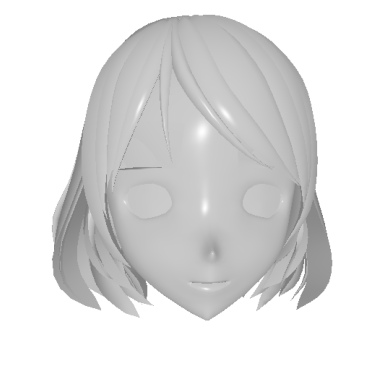

In [64]:
flame_mesh = Meshes(
    verts=[verts_neutral.to(device)],
    faces=[faces.verts_idx.to(device)],
    textures=tex
)

target_images = renderer(flame_mesh, cameras=cameras)
render_np = target_images[0][..., :3].detach().cpu().numpy()

_, ax = plt.subplots()
ax.imshow(render_np)
ax.axis(False);

### Mouth openning

In [65]:
def render_verts(verts_sequence, faces, texture, output_file="output.mp4"):
    writer = imageio.get_writer(output_file, fps=25, macro_block_size=1)

    for verts in verts_sequence:
        # create a mesh and render it
        flame_mesh = Meshes(
            verts=[verts.to(device)],
            faces=[faces.verts_idx.to(device)],
            textures=texture
        )
        rendered_frame = renderer(flame_mesh, cameras=cameras)
        rendered_frame_np = rendered_frame[0][..., :3].detach().cpu().numpy()

        # write the rendered frame into a video
        writer.append_data(np.uint8(rendered_frame_np * 255))

    writer.close()

In [56]:
# we don't load faces this time as they stay the same
verts_jaw_open, _, _ = load_obj("shape_keys/jawOpen.obj")

alphas = np.linspace(0.0, 1.0, 100)
all_vertices = [(1 - alpha) * verts_neutral + alpha * verts_jaw_open for alpha in alphas]
render_verts(all_vertices, faces, tex, output_file="mouth_openning.mp4")

### Full animation

In [57]:
shape_keys_path = Path("shape_keys")
shape_deltas = dict()

for key in blendshape_names:
    cur_path = shape_keys_path / (key + ".obj")
    cur_verts, _, _ = load_obj(cur_path)
    shape_deltas[key] = cur_verts - verts_neutral

In [59]:
all_vertices = []
for frame_idx in range(video_coeffs.shape[0]):
    cur_coeffs = dict(zip(blendshape_names, video_coeffs[frame_idx]))
    
    weighted_deltas = 0.0
    for key in cur_coeffs.keys():
        weighted_deltas += cur_coeffs[key] * shape_deltas[key]
    all_vertices.append(verts_neutral + weighted_deltas)

render_verts(all_vertices, faces, tex, output_file="coeff_visualization.mp4")